# Characteristics of USTS

Most often, TS are considered with evenly spaced time between observations. This type of TS is called evenly spaced (or regularly sampled, or uniformly sampled) time series (ESTS). They are defined as the sequence of observation $\{X_n\} = \{x_1, \dots, x_n\}$ taken in times $\{T_n\} = \{t_1, \dots, t_n\}$, where $n$ is the number of observations. The equation (1) is true for the sequence of times $\{T_n\}$.

$ t_{j+1} - t_{j} = t_{j} - t_{j-1}, \forall j \in {2, \dots, n - 1} $ (1)

Because of this behavior, it is possible to apply subtraction and division and get the sequence of times $\{T_n\} = \{1,2, \dots, n\}$. So when an ESTS is used, then it is written as $\{X_n\}$ where $n:= 1,2,\dots,n$ and observation times are unnecessary.   
    
There are also types of TS where the times of observations are paced by a monitored process and cannot be chosen. However, these TS do not have times, $\{T_n\}$, which satisfy equation (1). That means a TS of observations $ \{X_n\} = \{x_1, x_2, \dots, x_n\}$ taken at times $ \{T_n\} = \{t_1, t_2, \dots, t_n\}$ has the times, that are, in general, not regularly spaced, that mean, $ \delta_j = t_{j+1} - t_{j}, \forall j \in \{1,\dots, n-1\} $, is not constant. They are called unevenly spaced (or unequally spaced, or irregularly sampled) time series (USTS).

The basic model used for modeling TS is an additive model. The additive model of TS is defined for time series $\{X_n\}$ as follows:

$  x_t = \mathcal{T}_t + \mathcal{S}_t + \epsilon_t   $ (2)        


where $x_t \in \{X_n\}$ is an observation taken in time $t \in \{T_n\}$, $\mathcal{T}$ is the trend component, $\mathcal{S}$ is the seasonal component, and $\epsilon$ is an irregular component, that represents the noise or random component.
    
Suppose we want to perform a time series analysis (TSA) of TS $\{X_n\}$, then it is necessary to extract trend and seasonal components beforehand. This process is called time series decomposition (TSD). For example, when forecasting TS, we need to know all components from equation (2). However, without TSD, we cannot get a suitable model of the TS. Furthermore, TSD is usually done by hand, and it is problematic to process it automatically.

Multiple types of USTS from network traffic are designated by what represents one data point and by what data points have in common. In this paper, we define three types: Packet Time Series, Flow Time Series, Single Flow Time Series.

## Packet Time Series

A Packet Time Series (PTS) from network traffic is TS, where a data point represents a network packet. Furthermore, PTS is a univariate TS with a variable number of bytes in the network packet. The time information $t_i \in \mathbb{R}$ of $i$-th data point is defined by transmission time of $i$-th packet. So PTS are inevitably USTS.

## Flow Time Series

A flow represents aggregated information from a sequence of packets with the same attributes in the packet headers. The advantage of flow monitoring is a smaller volume of data to process, e.g., by detection systems.

## Single Flow Time Series
Since PTS may contain packets of any connection together, it is useful create also separated time series. Such TS that contains a packet sequence of just a single flow is called a Single Flow Time Series (SFTS).


### Load libraries

In [2]:
import pandas as pd
import sys
import csv
csv.field_size_limit(sys.maxsize)
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import math
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

## Hurst exponent

As part of our analysis and experiments focused on behavior of USTS from network traffic, we performed tests using the Hurst exponent calculated by the procedure from the article [1]. The Hurst exponent $H$ can detect a TS tendency to regress to the mean or cluster towards the center strongly. If $H \in \left< 0 ; 0.5 \right) $, then it indicates a long-term switching between high and low values in adjacent pairs, which means that if the value of one data point is low, the following data point tends to have a high value. It is also stated that the TS is anti-persistent. If $H \sim 0.5$, then this indicates a random (uncorrelated) TS. Furthermore, if $H \in \left( 0.5 ; 1\right>$, then it indicates a long-term positive autocorrelation in the TS. It is also said that the TS is persistent. For the Hurst exponent, it holds:
        

$ E\left[ \frac{R(n)}{S(n)} \right] = Cn^H $
        
where $R(n)$ is the first $n$ cumulative deviations from the mean, $S(n)$ is the sum of the first $n$ standard deviations, $E$ is the expected value, $n$ is the number of data points in the TS, and $C$ is a constant. 

Following code of Hurst exponent for unevenly spaced time series is based on the paper [2].



[1] A. A. Anis and E. H. Lloyd. The expected value of the adjusted rescaled hurst range of independent normal summands. Biometrika, 63(1):111–116, 1976.

[2] Ji, Li-Jun, et al. "R/S method for unevenly sampled time series: Application to detecting long-term temporal dependence of droplets transiting through a fixed spatial point in gas–liquid two-phase turbulent jets." Physica A: Statistical Mechanics and its Applications 388.17 (2009): 3345-3354.

In [3]:
def hurst_rs(ts, times):
    ts = ts - np.mean(ts)
    n = len(ts)
    cum_r = np.zeros(n)
    s_vals = np.zeros(n)
    
    # calculate cumulative sum and cumulative difference of ts
    for i in range(1, n):
        cum_r[i] = cum_r[i-1] + ts[i]
        s_vals[i] = s_vals[i-1] + (ts[i] - ts[i-1])
    
    # rescale s_vals and cum_r
    s_rescaled = np.zeros(n)
    r_s_rescaled = np.zeros(n)
    for i in range(n):
        s_rescaled[i] = s_vals[i] / np.sqrt(cum_r[i])
        r_s_rescaled[i] = cum_r[i] / np.sqrt(cum_r[n-1])
    
    # calculate q_actual
    q_actual = np.zeros(n)
    for i in range(n):
        tmp =  norm.ppf((times[i] - times[0] + 1) / (times[-1] - times[0] + 1))
        if tmp == np.inf:
            q_actual[i] = 0
        else:    
            q_actual[i] = norm.ppf((times[i] - times[0] + 1) / (times[-1] - times[0] + 1))
    
    # calculate Hurst exponent
    q_range = np.max(q_actual) - np.min(q_actual)
    std_q = np.std(q_actual)
    hurst = np.log10(q_range / std_q) / np.log10(n)
    
    return 1 - hurst

In [4]:
ts = np.array([1, 3, 5, 7, 9, 2, 4, 6, 8, 10,1, 3, 5, 7, 9, 2, 4, 6, 8, 10])
times = np.array([1, 2, 3, 5, 6, 8, 9, 10, 12, 13, 14,15,16,17,18,19,20,21,22,23])
hurst_exp = hurst_rs(ts, times)
print(hurst_exp)

0.5485087922683799


# Stationarity

According to [1], properties of a stationary TS do not depend on the time of observation. So TS with a trend or with seasonality are not stationary. Nevertheless, the TS with periodic (or cyclic) behavior without trend and seasonality is stationary. 


### Augmented Dickey-Fuller test

Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


[1] Denis Kwiatkowski et al. Testing the null hypothesis of stationarity against the alternative of a unit root: How sure are we that economic time series have a unit root? Journal of Econometrics, 1992.

In [8]:
result = adfuller(ts)
print(result[1])
result[1] <= 0.05

0.0


True

# Experiments

## Process FTS

This procedure takes a lot of time.

In [152]:
n_flows = 0
with open("fts.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    for row in reader:
        n_flows += int(row[1])
n_flows

259427372

In [ ]:
cnt = 0
print(f"\r{cnt}",end="")
    
with open("fts.characteristics_.csv", "w") as w:
    writer = csv.writer(w)
    writer.writerow(["LENGTH", "DURATION","H_BYTES", "STATIONARITY_PACKETS", "STATIONARITY_BYTES", "OVERALL_STATIONARITY"])
    with open("fts.csv", "r") as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            packets = np.array(json.loads(row[4]))
            
            if len(packets) < 5:
                continue
            bytes = np.array(json.loads(row[5]))
            t1 = np.array(json.loads(row[6]))
            t2 = np.array(json.loads(row[7]))
            H_bytes = hurst_rs(bytes[:1000], t1[:1000])
            S_packets = adfuller(packets[:1000])
            if S_packets[1] <= 0.05 or  str(S_packets[1]) == "nan":
                S_packets = True
            else:
                S_packets = False
            S_bytes = adfuller(bytes[:1000])
            if S_bytes[1] <= 0.05 or str(S_bytes[1]) == "nan":
                S_bytes = True
            else:
                S_bytes = False
            if S_bytes is True or S_packets is True :
                S = True
            else:
                S = False
            writer.writerow([len(packets), t2[-1] - t1[0], H_bytes, S_packets, S_bytes, S])
            cnt += 1
            print(f"\r{cnt}",end="",flush=False)

## Process PTS

This procedure takes a lot of time.

In [153]:
n_packets = 0
with open("pts.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    for row in reader:
        if row[0] == "ID_DEPENDENCY":
            continue
        bytes = np.array(json.loads(row[1]))
        n_packets += len(bytes)
n_packets

110047786

In [140]:
cnt = 0
with open("pts.characteristics_.csv", "w") as w:
    writer = csv.writer(w)
    writer.writerow(["LENGTH", "DURATION", "H", "STATIONARITY"])
    print(f"\r{cnt}",end="")    
    with open("pts.csv", "r") as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            if row[0] == "ID_DEPENDENCY":
                continue
            bytes = np.array(json.loads(row[1]))
            if len(bytes) < 5:
                continue
            times = np.array(json.loads(row[2]))
            
            H = hurst_rs(bytes[:1000], times[:1000])
            S = adfuller(bytes[:1000])
            if S[1] <= 0.05  or str(S[1]) == "nan":
                S = True
            else:
                S = False
            writer.writerow([len(bytes), times[-1] - times[0], H, S])
            cnt += 1
            print(f"\r{cnt}",end="",flush=False)
    print("")

## Process SFTS

This procedure takes a lot of time.

In [154]:
n_packets = 0
with open("sfts.csv", "r") as f:
   reader = csv.reader(f, delimiter=";")
   for row in reader:
     if row[0] == "SRC_IP":
        continue
     bytes = np.array(json.loads(row[4]))
     n_packets += len(bytes)
n_packets

160142235

In [32]:
cnt = 0
print(f"\r{cnt}",end="")    
with open("sfts.characteristics_.csv", "w") as w:
    writer = csv.writer(w)
    writer.writerow(["LENGTH", "DURATION", "H", "STATIONARITY"])
    with open("sfts.csv", "r") as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            if row[0] == "SRC_IP":
                continue
            bytes = np.array(json.loads(row[4]))
            if len(bytes) < 5:
                continue
            times = np.array(json.loads(row[5]))
            H = hurst_rs(bytes[:1000], times[:1000])
            S = adfuller(bytes[:1000])
            if S[1] <= 0.05  or str(S[1]) == "nan":
                S = True
            else:
                S = False
            writer.writerow([len(bytes), times[-1] - times[0], H, S])
            cnt += 1
            print(f"\r{cnt}",end="",flush=False)

1438206

### Analysis of experiment results

In [82]:
df_fts = pd.read_csv("fts.characteristics.csv")
df_fts

,LENGTH,DURATION,H_BYTES,STATIONARITY_PACKETS,STATIONARITY_BYTES,OVERALL_STATIONARITY
0,24,83396.079,0.540338,False,False,False
1,88,80107.838,0.519504,True,True,True
2,102,82589.414,0.612705,True,True,True
3,29674,83464.910,0.766579,True,True,True
4,601359,6054.336,NaN,True,True,True
...,...,...,...,...,...,...
843325,6,56496.932,0.383938,False,False,False
843326,38,82513.243,0.509663,True,True,True
843327,8,9194.666,0.516192,True,False,True
843328,58,79092.969,0.590620,True,True,True


In [83]:
df_pts = pd.read_csv("pts.characteristics.csv")
df_pts

,LENGTH,DURATION,H,STATIONARITY
0,1793,16606.0,0.846519,True
1,21,2.0,0.719657,False
2,26,3.0,0.698855,True
3,21,3.0,0.719657,False
4,5280,17226.0,0.775900,True
...,...,...,...,...
543454,11,0.0,NaN,True
543455,50,3.0,0.769243,True
543456,13,0.0,NaN,False
543457,204133,21599.0,0.766584,True


In [84]:
df_sfts = pd.read_csv("sfts.characteristics.csv")
df_sfts

,LENGTH,DURATION,H,STATIONARITY
0,15,122.990759,0.584012,False
1,8,15.764988,0.620730,True
2,8,9.200007,0.498617,True
3,8,5.650508,0.590353,False
4,8,0.748292,0.594737,True
...,...,...,...,...
1438201,25,1.470138,0.704875,True
1438202,25,1.470144,0.704134,True
1438203,25,1.470118,0.704305,True
1438204,25,1.470102,0.704761,True


#### Hurst exponent distribution

In [85]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [86]:
def get_Hs_dict(Hs, lengths=None, l=0, bins=100):
    _Hs_ = {0.0:0, 1.0:0}
    for i in range(1,10):
        if i/10 not in _Hs_:
            _Hs_[i/10] = 0
    if lengths is not None:
        for i, j in zip(Hs, lengths):
            if i == 1 or math.isnan(i):
                continue
            if j < l:
                continue
            tmp = float("{:0.2f}".format(i))
            if (tmp*bins) % 2 != 0:
                tmp = ((tmp*bins) - (tmp*bins) % 2) / bins
            if tmp not in _Hs_:
                _Hs_[tmp] = 0
            _Hs_[tmp] += 1            
    else:
        s = 0
        for i in Hs:
            if i == 1 or math.isnan(i):
                continue
            if i < 0 or i > 1:
                continue
            s += i
            tmp = float("{:0.2f}".format(i))
            if (tmp*bins) % 2 != 0:
                tmp = ((tmp*bins) - (tmp*bins) % 2) / bins
            if tmp not in _Hs_:
                _Hs_[tmp] = 0
            _Hs_[tmp] += 1
    # s = sum(Hs)
    for i in _Hs_:
        _Hs_[i] = _Hs_[i] / s
    return _Hs_

def get_x_y(d):
    s = sum(d.values())
    x = []
    y = []
    for k in sorted(d):
        x.append(k)
        y.append((d[k] / s) * 100)
    return x, y

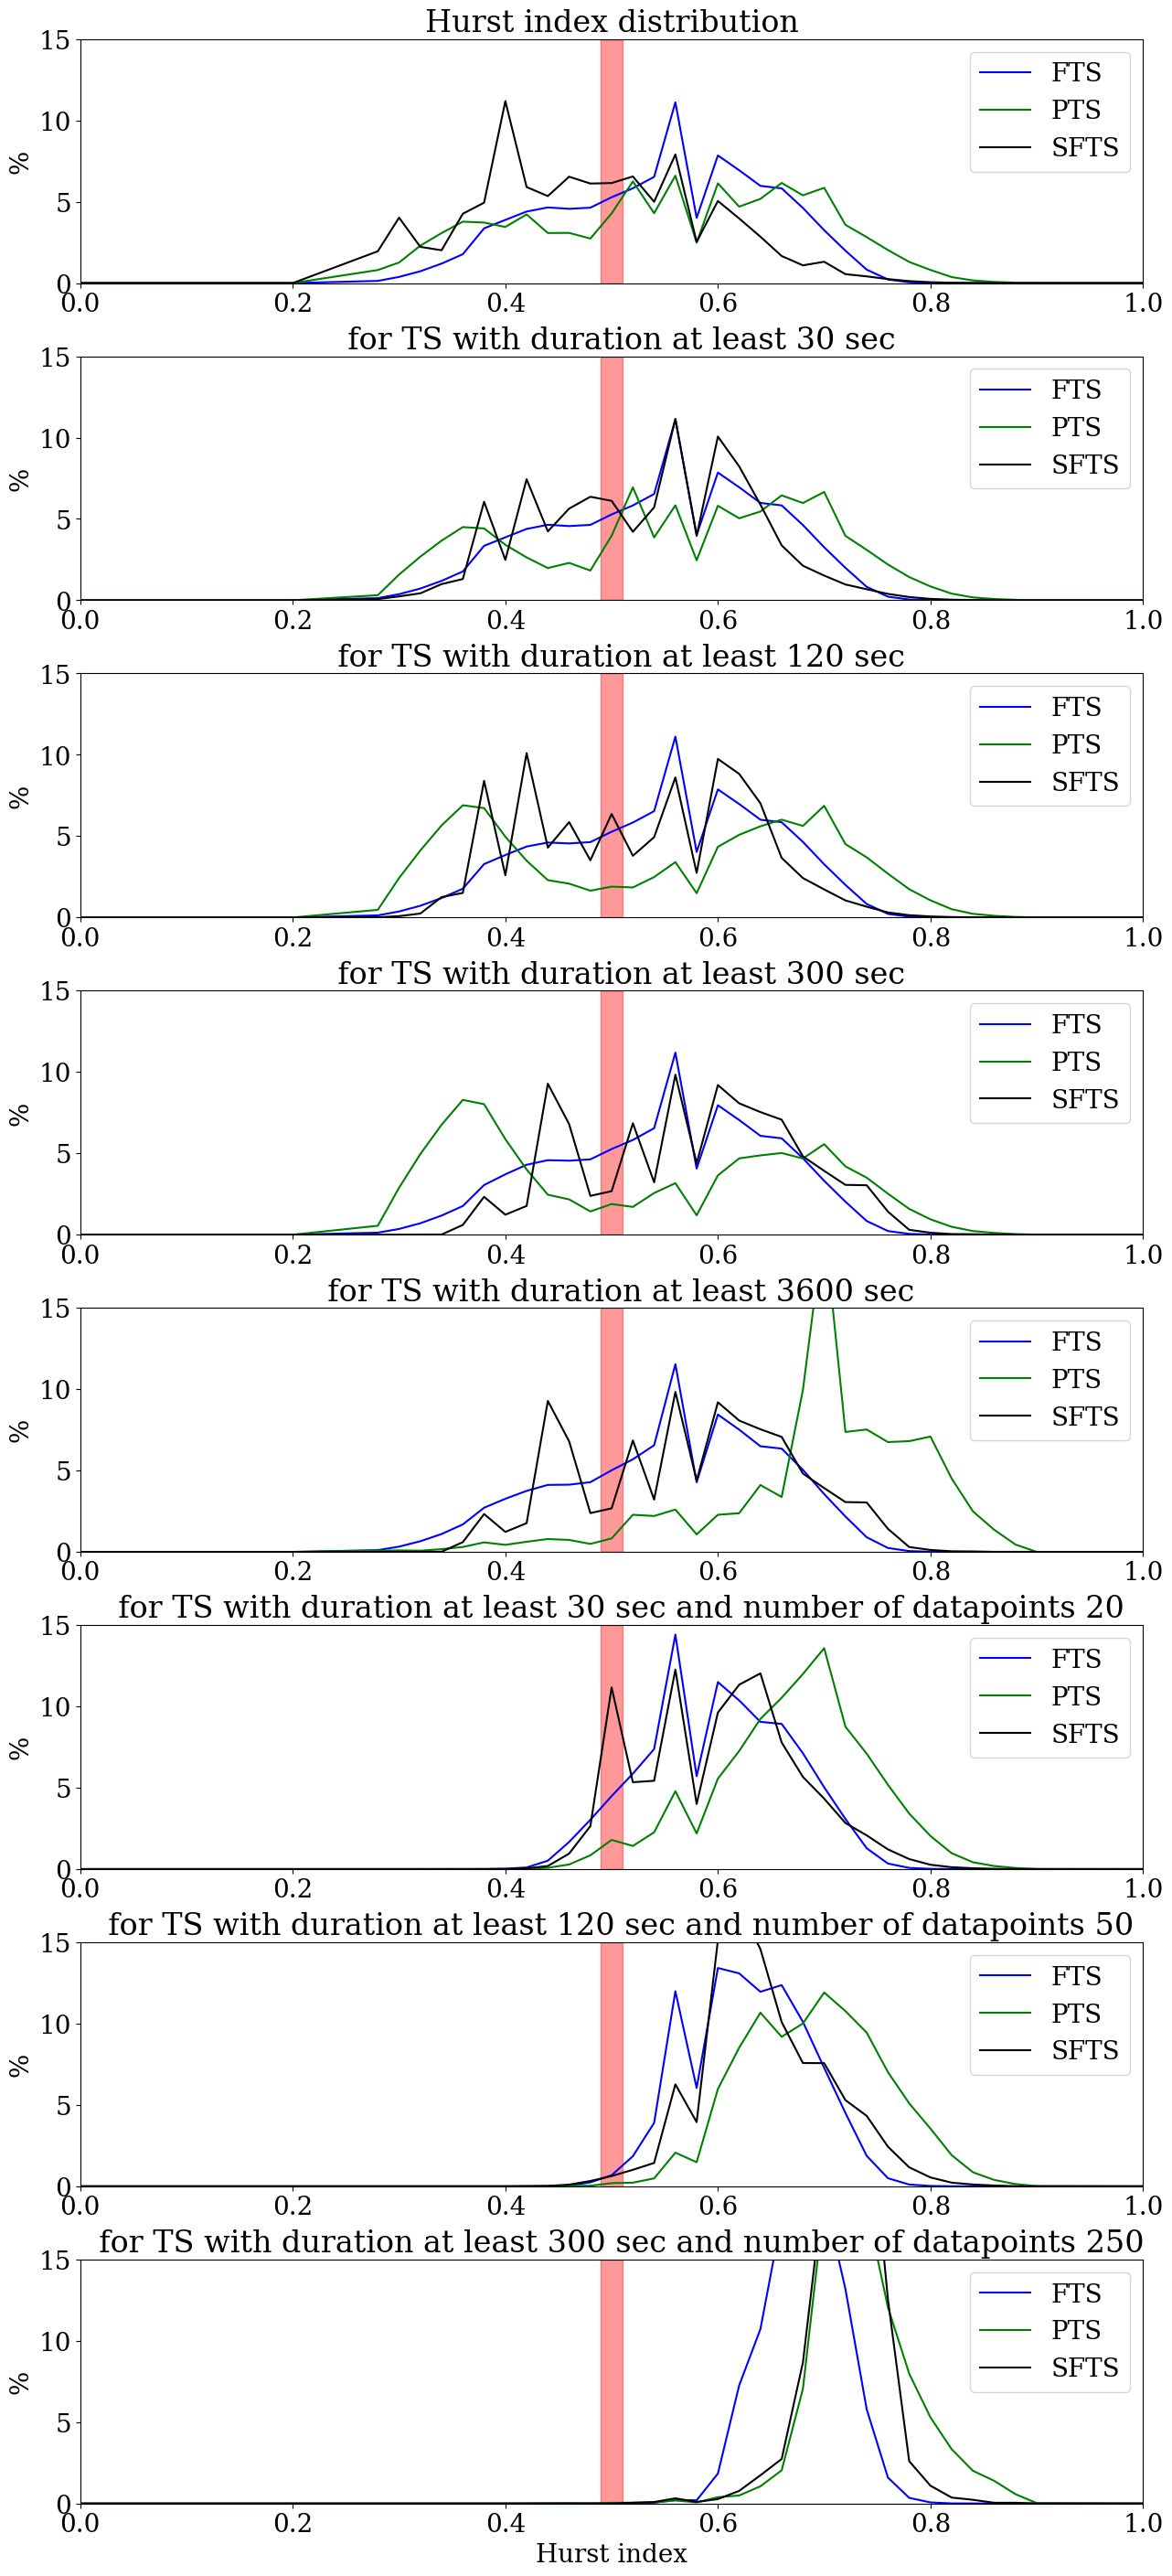

In [87]:
fig, ax = plt.subplots(8, 1,figsize=(15,35), )
fig.subplots_adjust(hspace=.3)

def plot_subplot(_ax, _flow_, _packet_, _single_flow_, title=""):
    x_flow, y_flow = get_x_y(_flow_)
    _ax.plot(x_flow, y_flow, color="blue", label="FTS")
    x_packet, y_packet = get_x_y(_packet_)
    _ax.plot(x_packet, y_packet, color="green", label="PTS")
    if _single_flow_ is not None:
        x_single_flow, y_single_flow = get_x_y(_single_flow_)
        _ax.plot(x_single_flow, y_single_flow, color="black", label="SFTS")
    _ax.axvspan(0.49, 0.51, color='red', alpha=0.4)
    _ax.legend()
    _ax.set_xlim(0,1)
    _ax.set_ylim(0,15)
    _ax.set_ylabel("%")
    _ax.set_title(title)

def perform_plot(index, d, l, title=""):
    _flow_ = get_Hs_dict(list(df_fts[df_fts.DURATION >= d][df_fts.LENGTH >= l][df_fts.H_BYTES.notnull()].H_BYTES), bins=100)
    _packet_ = get_Hs_dict(list(df_pts[df_pts.DURATION >= d][df_pts.LENGTH >= l][df_pts.H.notnull()].H), bins=100)
    if d >= 300:
        d = 299
    _single_flow_ = get_Hs_dict(list(df_sfts[df_sfts.DURATION >= d][df_sfts.LENGTH >= l][df_sfts.H.notnull()].H), bins=100)
    plot_subplot(ax[index], _flow_, _packet_, _single_flow_, title=title)

perform_plot(0, 0, 0, title="Hurst index distribution")
perform_plot(1, 30, 0, title="  for TS with duration at least 30 sec")
perform_plot(2, 120, 0, title="  for TS with duration at least 120 sec")
perform_plot(3, 300, 0, title="  for TS with duration at least 300 sec")
perform_plot(4, 3600, 0, title="  for TS with duration at least 3600 sec")
perform_plot(5, 30, 20, title="  for TS with duration at least 30 sec and number of datapoints 20")
perform_plot(6, 120, 50, title="  for TS with duration at least 120 sec and number of datapoints 50")
perform_plot(7, 300, 250, title="  for TS with duration at least 300 sec and number of datapoints 250")

plt.xlabel("Hurst index")
plt.show()

In [88]:
def plot_table_hurst(df, title=""):
    fig, ax =plt.subplots(1,1, figsize=(10,3.5))
    ax.axis('tight')
    ax.axis('off')
    # np.concatenate((df_stat_fts.values,df_stat_pts.values,df_stat_sfts.values),axis=0)
    table = ax.table(cellText=df.values,
            colLabels=df.columns,
            loc="center",
            cellLoc="left")
    table.scale(1, 4)

    normal = cm.colors.Normalize(0, 100)
    bcmap2 = plt.cm.Greens(normal(df["0.0 - 0.5"]))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 1)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df["0.5"]))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 2)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df["0.5 - 1.0"]))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 3)].set_facecolor(bb)
    for i in range(0, 4):
        table[(0, i)].set_facecolor([0.        , 0, 0.2, 0.2  ])
    for i in range(0, 4):
        table[(i, 0)].set_facecolor([0.        , 0, 0.2, 0.2  ])
        
    plt.title(title)
    plt.show()
    
def get_values_for_hurst_table(_flow_, _packet_, _single_flow_):
    s_flow = 0
    for key, value in _flow_.items():
        if key < 0.5:
            s_flow += value
    s_packet = 0
    for key, value in _packet_.items():
        if key < 0.5:
            s_packet += value
    s_single_flow = 0
    for key, value in _single_flow_.items():
        if key < 0.5:
            s_single_flow += value
    return s_flow, s_packet, s_single_flow

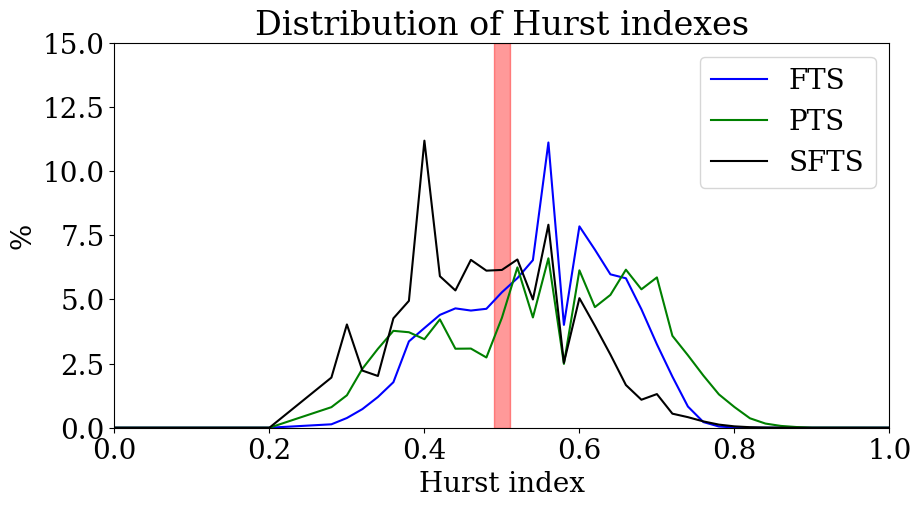

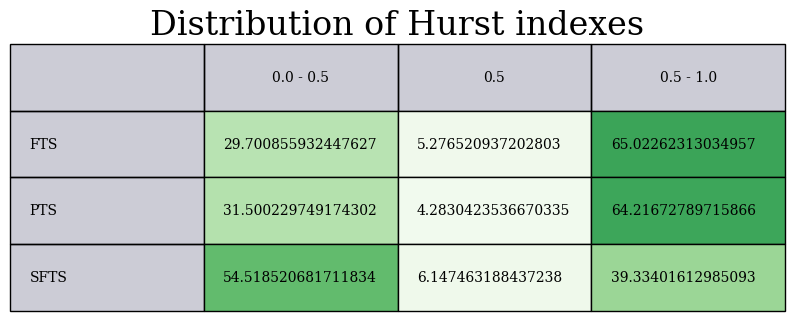

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
fig.subplots_adjust(hspace=.3)

d = 0
l = 0
_flow_ = get_Hs_dict(list(df_fts[df_fts.DURATION >= d][df_fts.LENGTH >= l][df_fts.H_BYTES.notnull()].H_BYTES), bins=100)
_packet_ = get_Hs_dict(list(df_pts[df_pts.DURATION >= d][df_pts.LENGTH >= l][df_pts.H.notnull()].H), bins=100)
_single_flow_ = get_Hs_dict(list(df_sfts[df_sfts.DURATION >= d][df_sfts.LENGTH >= l][df_sfts.H.notnull()].H), bins=100)
plot_subplot(ax, _flow_, _packet_, _single_flow_, title="Distribution of Hurst indexes")

plt.xlabel("Hurst index")
plt.show()

s_flow, s_packet, s_single_flow = get_values_for_hurst_table(_flow_, _packet_, _single_flow_)
hurst_exponent_filtered = [
    ["", "0.0 - 0.5", "0.5", "0.5 - 1.0"],
    ["FTS", s_flow/sum(_flow_.values()), _flow_[0.5]/sum(_flow_.values()), (sum(_flow_.values()) - s_flow - _flow_[0.5])/sum(_flow_.values())],
    ["PTS", s_packet/sum(_packet_.values()), _packet_[0.5]/sum(_packet_.values()), (sum(_packet_.values()) - s_packet - _packet_[0.5])/sum(_packet_.values())],
    ["SFTS", s_single_flow / sum(_single_flow_.values()), _single_flow_[0.5] / sum(_single_flow_.values()), (sum(_single_flow_.values()) - s_single_flow - _single_flow_[0.5])/sum(_single_flow_.values())],
]
df_stat_hurst_filter = pd.DataFrame(hurst_exponent_filtered[1:], columns=hurst_exponent_filtered[0])
for key in list(df_stat_hurst_filter.keys()):
    if key == "":
        continue
    df_stat_hurst_filter[key] = df_stat_hurst_filter[key]*100
plot_table_hurst(df_stat_hurst_filter, title="Distribution of Hurst indexes")

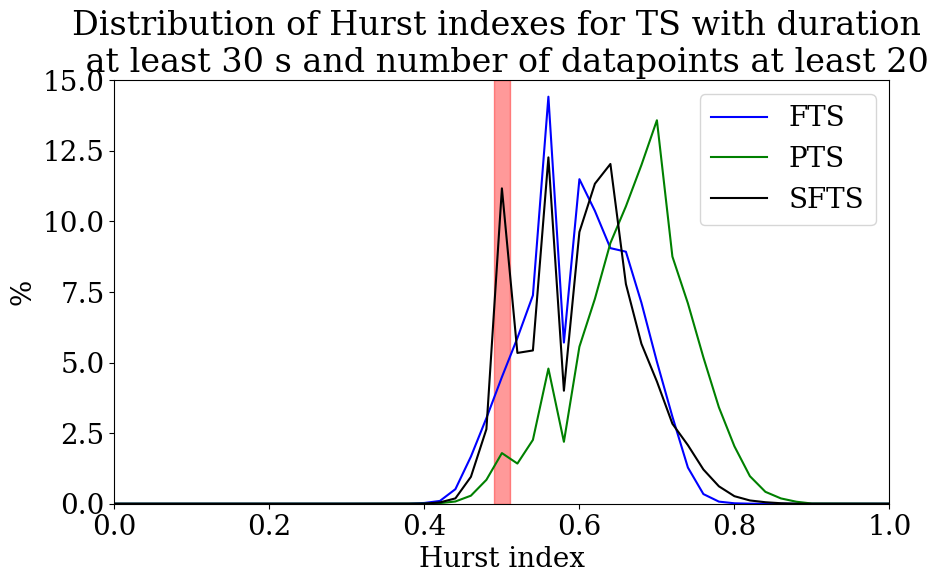

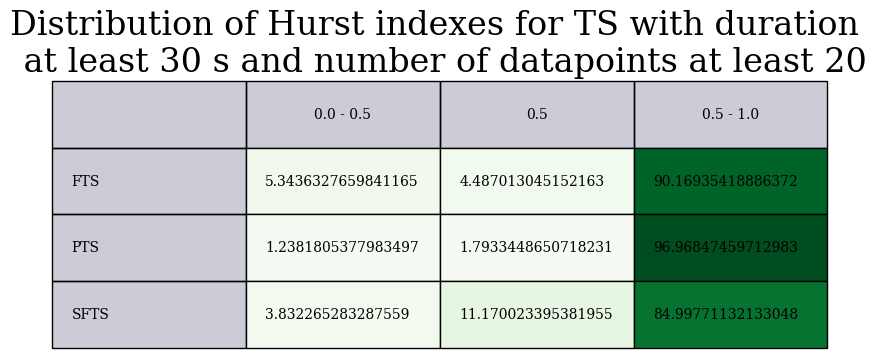

In [101]:
fig, ax = plt.subplots(figsize=(10,5.5))
fig.subplots_adjust(hspace=.3)

d = 30
l = 20
_flow_ = get_Hs_dict(list(df_fts[df_fts.DURATION >= d][df_fts.LENGTH >= l][df_fts.H_BYTES.notnull()].H_BYTES), bins=100)
_packet_ = get_Hs_dict(list(df_pts[df_pts.DURATION >= d][df_pts.LENGTH >= l][df_pts.H.notnull()].H), bins=100)
_single_flow_ = get_Hs_dict(list(df_sfts[df_sfts.DURATION >= d][df_sfts.LENGTH >= l][df_sfts.H.notnull()].H), bins=100)
plot_subplot(ax, _flow_, _packet_, _single_flow_, title="Distribution of Hurst indexes for TS with duration \n at least 30 s and number of datapoints at least 20")

plt.xlabel("Hurst index")
plt.show()

s_flow, s_packet, s_single_flow = get_values_for_hurst_table(_flow_, _packet_, _single_flow_)
hurst_exponent_filtered = [
    ["", "0.0 - 0.5", "0.5", "0.5 - 1.0"],
    ["FTS", s_flow/sum(_flow_.values()), _flow_[0.5]/sum(_flow_.values()), (sum(_flow_.values()) - s_flow - _flow_[0.5])/sum(_flow_.values())],
    ["PTS", s_packet/sum(_packet_.values()), _packet_[0.5]/sum(_packet_.values()), (sum(_packet_.values()) - s_packet - _packet_[0.5])/sum(_packet_.values())],
    ["SFTS", s_single_flow / sum(_single_flow_.values()), _single_flow_[0.5] / sum(_single_flow_.values()), (sum(_single_flow_.values()) - s_single_flow - _single_flow_[0.5])/sum(_single_flow_.values())],
]
df_stat_hurst_filter = pd.DataFrame(hurst_exponent_filtered[1:], columns=hurst_exponent_filtered[0])
for key in list(df_stat_hurst_filter.keys()):
    if key == "":
        continue
    df_stat_hurst_filter[key] = df_stat_hurst_filter[key]*100
plot_table_hurst(df_stat_hurst_filter, title="Distribution of Hurst indexes for TS with duration \n at least 30 s and number of datapoints at least 20")

#### Stationarity

In [92]:
def get_percent(df, column, d1, d2, n1,n2):
    df_tmp = df
    if d1 != -1:
        df_tmp = df_tmp[df_tmp.DURATION >= d1]
    if d2 != -1:
        df_tmp = df_tmp[df_tmp.DURATION < d2]
    if n1 != -1:
        df_tmp = df_tmp[df_tmp.LENGTH >= n1]
    if n2 != -1:
        df_tmp = df_tmp[df_tmp.LENGTH < n2]
    return df_tmp[column].sum() / df_tmp[column].count()

def fill_row(table, row_index, df, column, d1, d2):
    table[row_index][1] = get_percent(df, column, d1, d2, -1, -1)
    table[row_index][2] = get_percent(df, column, d1, d2, 0, 25)
    table[row_index][3] = get_percent(df, column, d1, d2, 25, 100)
    table[row_index][4] = get_percent(df, column, d1, d2, 100, 500)
    table[row_index][5] = get_percent(df, column, d1, d2, 500, 1000)
    table[row_index][6] = get_percent(df, column, d1, d2, 1000, -1)

def plot_table(df, title="Percentage of Stationarity FTS"):
    fig, ax =plt.subplots(1,1, figsize=(15,5.5))
    ax.axis('tight')
    ax.axis('off')
    # np.concatenate((df_stat_fts.values,df_stat_pts.values,df_stat_sfts.values),axis=0)
    table = ax.table(cellText=df.values,
            colLabels=df.columns,
            loc="center",
            cellLoc="left")
    table.scale(1, 4)
    
    normal = cm.colors.Normalize(0, 100)
    bcmap2 = plt.cm.Greens(normal(df['all']))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 1)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df['< 25']))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 2)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df['25 - 100']))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 3)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df['100 - 500']))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 4)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df['500 - 1000']))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 5)].set_facecolor(bb)
    bcmap2 = plt.cm.Greens(normal(df['>= 1000']))
    for idx, bb in enumerate(bcmap2):
        table[(idx+1, 6)].set_facecolor(bb)

    for i in range(0, 7):
        table[(0, i)].set_facecolor([0.        , 0, 0.2, 0.2  ])

    for i in range(0, 6):
        table[(i, 0)].set_facecolor([0.        , 0, 0.2, 0.2  ])
        
    plt.title(title)
    plt.show()

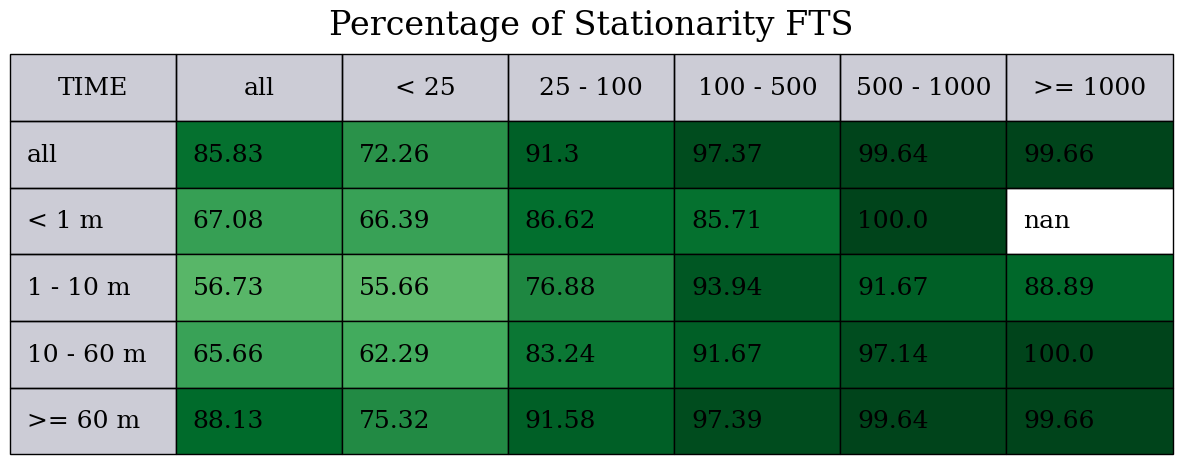

In [93]:
fts_stationarity = [
    ["TIME", "all", "< 25", "25 - 100", "100 - 500", "500 - 1000",">= 1000"],
    ["all", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["< 1 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["1 - 10 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["10 - 60 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [">= 60 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
]

# 1. row
fill_row(fts_stationarity, 1, df_fts, "OVERALL_STATIONARITY", -1, -1)
# 2. row
fill_row(fts_stationarity, 2, df_fts, "OVERALL_STATIONARITY", 0, 60)
# 3. row
fill_row(fts_stationarity, 3, df_fts, "OVERALL_STATIONARITY", 60, 600)
# 4. row
fill_row(fts_stationarity, 4, df_fts, "OVERALL_STATIONARITY", 600, 3600)
# 5. row
fill_row(fts_stationarity, 5, df_fts, "OVERALL_STATIONARITY", 3600, -1)

df_stat_fts = pd.DataFrame(fts_stationarity[1:], columns=fts_stationarity[0])
for key in list(df_stat_fts.keys()):
    if key == "TIME":
        continue
    df_stat_fts[key] = df_stat_fts[key]*100
    df_stat_fts[key] = df_stat_fts[key].round(2)

plot_table(df_stat_fts, title="Percentage of Stationarity FTS")

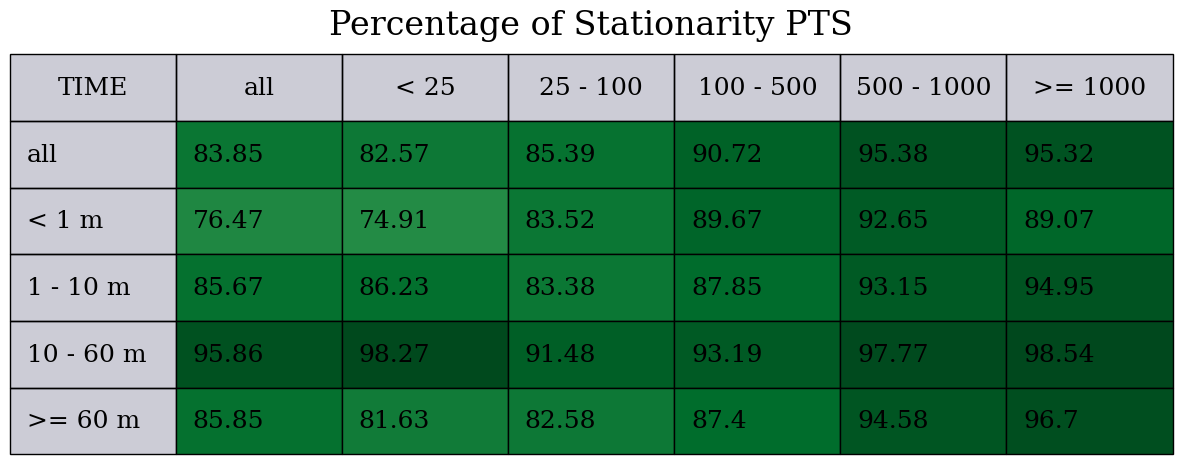

In [94]:
pts_stationarity = [
    ["TIME", "all", "< 25", "25 - 100", "100 - 500", "500 - 1000",">= 1000"],
    ["all", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["< 1 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["1 - 10 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["10 - 60 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [">= 60 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
]

# 1. row
fill_row(pts_stationarity, 1, df_pts, "STATIONARITY", -1, -1)
# 2. row
fill_row(pts_stationarity, 2, df_pts, "STATIONARITY", 0, 60)
# 3. row
fill_row(pts_stationarity, 3, df_pts, "STATIONARITY", 60, 600)
# 4. row
fill_row(pts_stationarity, 4, df_pts, "STATIONARITY", 600, 3600)
# 5. row
fill_row(pts_stationarity, 5, df_pts, "STATIONARITY", 3600, -1)

df_stat_pts = pd.DataFrame(pts_stationarity[1:], columns=pts_stationarity[0])
for key in list(df_stat_pts.keys()):
    if key == "TIME":
        continue
    df_stat_pts[key] = df_stat_pts[key]*100
    df_stat_pts[key] = df_stat_pts[key].round(2)

plot_table(df_stat_pts, title="Percentage of Stationarity PTS")

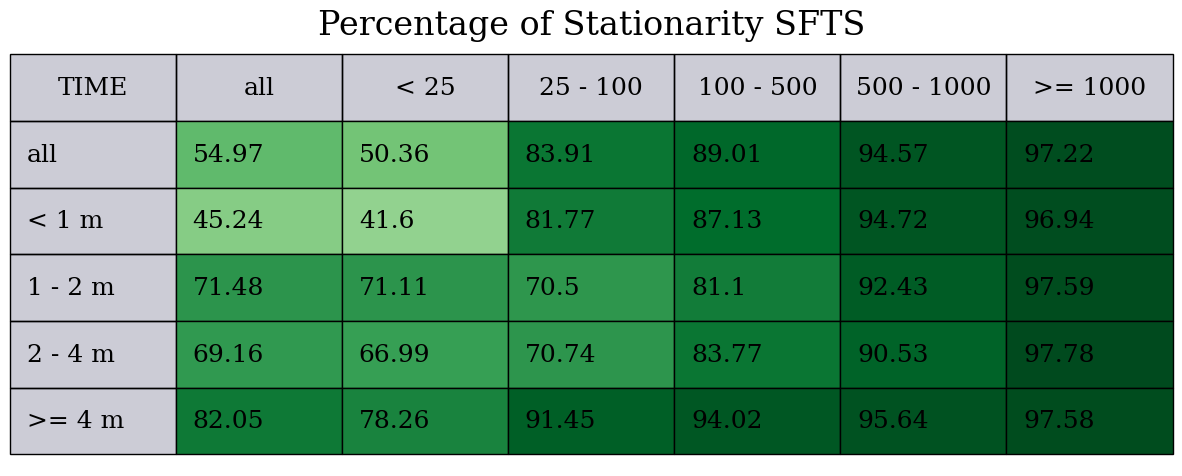

In [95]:
sfts_stationarity = [
    ["TIME", "all", "< 25", "25 - 100", "100 - 500", "500 - 1000",">= 1000"],
    ["all", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["< 1 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["1 - 2 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    ["2 - 4 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [">= 4 m", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
]

# 1. row
fill_row(sfts_stationarity, 1, df_sfts, "STATIONARITY", -1, -1)
# 2. row
fill_row(sfts_stationarity, 2, df_sfts, "STATIONARITY", 0, 60)
# 3. row
fill_row(sfts_stationarity, 3, df_sfts, "STATIONARITY", 60, 120)
# 4. row
fill_row(sfts_stationarity, 4, df_sfts, "STATIONARITY", 120, 240)
# 5. row
fill_row(sfts_stationarity, 5, df_sfts, "STATIONARITY", 240, -1)

df_stat_sfts = pd.DataFrame(sfts_stationarity[1:], columns=sfts_stationarity[0])
for key in list(df_stat_sfts.keys()):
    if key == "TIME":
        continue
    df_stat_sfts[key] = df_stat_sfts[key]*100
    df_stat_sfts[key] = df_stat_sfts[key].round(2)

plot_table(df_stat_sfts, title="Percentage of Stationarity SFTS")